In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import utils

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
gdp = pd.read_csv('../dataset/social-spending-oecd-longrun.csv')
alco = pd.read_csv('../dataset/rate-of-premature-deaths-due-to-alcohol.csv')

In [3]:
display(gdp.head())
display(alco.head())

,Entity,Code,Year,Social Expenditure %GDP - (OWID extrapolated series) (%)
0,Australia,AUS,1880,0
1,Australia,AUS,1890,0
2,Australia,AUS,1900,0
3,Australia,AUS,1910,1.12
4,Australia,AUS,1920,1.66


,Entity,Code,Year,Deaths - Alcohol use - Sex: Both - Age: Age-standardized (Rate) (Rate)
0,Afghanistan,AFG,1990,4.527867
1,Afghanistan,AFG,1991,3.969239
2,Afghanistan,AFG,1992,3.164372
3,Afghanistan,AFG,1993,2.561800
4,Afghanistan,AFG,1994,2.123057


### EDA

In [4]:
gdp = gdp[gdp.Year > 1990]

In [5]:
new = utils.nearestYear(gdp,alco)
new.head()

,Entity,Code,Year,Social Expenditure %GDP - (OWID extrapolated series) (%),RoundYear
29,Australia,AUS,1995,16.871,1995.0
30,Australia,AUS,2000,18.242,2000.0
31,Australia,AUS,2005,16.681,2005.0
32,Australia,AUS,2010,16.706,2010.0
33,Australia,AUS,2013,18.109,2013.0


In [6]:
# Merge two dataframe on years it matches and country name
df = pd.merge(alco, 
              new,  
              how='inner', left_on=['Entity','Year'], right_on = ['Entity','Year'], suffixes=['_alcohol','_gdp'])
# Rename Social Expediture percentage column
df.rename(columns={'Social Expenditure %GDP - (OWID extrapolated series) (%)': 'Percent_GDP','Deaths - Alcohol use - Sex: Both - Age: Age-standardized (Rate) (Rate)':'Deaths'},inplace=True)
# Delete row with  string '..' Convert object type to float
df = df[df.Percent_GDP != '..']
df.Percent_GDP = df.Percent_GDP.astype(float)
df = df[df.Percent_GDP != 0]
df.dropna(inplace = True)
mean = df.Percent_GDP.mean()
print('the average of percentage spend by countries is {}, the shape of the dataframe is {}'.format(mean,df.shape))

# Gini index indicates if it is higher than there is higher inequality
df.head()

the average of percentage spend by countries is 20.29715471698113, the shape of the dataframe is (265, 7)


,Entity,Code_alcohol,Year,Deaths,Code_gdp,Percent_GDP,RoundYear
0,Australia,AUS,1995,25.691102,AUS,16.871,1995.0
1,Australia,AUS,2000,21.606921,AUS,18.242,2000.0
2,Australia,AUS,2005,20.413080,AUS,16.681,2005.0
3,Australia,AUS,2010,21.497468,AUS,16.706,2010.0
4,Australia,AUS,2013,21.028834,AUS,18.109,2013.0


In [91]:
df.min()

Entity          Australia
Code_alcohol          AUS
Year                 1995
Deaths           -8.42654
Code_gdp              AUS
Percent_GDP         3.071
RoundYear            1995
dtype: object

In [7]:
def rangeOfPercent(percent):
    if percent < 17.5:
        return 15
    elif percent < 22.5:
        return 20
    else:
        return 25

In [8]:
#df.drop(['70 and older (deaths)','50-69 (deaths)','15-49 (deaths)','under 5 (deaths)'],axis=1,inplace=True)
df['Groups'] = df.Percent_GDP.apply(rangeOfPercent)
df.head()

,Entity,Code_alcohol,Year,Deaths,Code_gdp,Percent_GDP,RoundYear,Groups
0,Australia,AUS,1995,25.691102,AUS,16.871,1995.0,15
1,Australia,AUS,2000,21.606921,AUS,18.242,2000.0,20
2,Australia,AUS,2005,20.413080,AUS,16.681,2005.0,15
3,Australia,AUS,2010,21.497468,AUS,16.706,2010.0,15
4,Australia,AUS,2013,21.028834,AUS,18.109,2013.0,20


In [9]:
df.Groups.value_counts()

20    96
25    92
15    77
Name: Groups, dtype: int64

In [11]:
fif = df[df['Groups'] == 15]
twenty = df[df['Groups'] == 20]
tfive = df[df['Groups'] == 25]

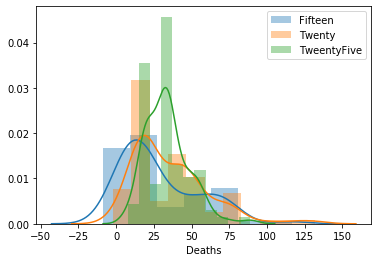

In [12]:

sns.distplot(fif['Deaths'],label='Fifteen')
sns.distplot(twenty['Deaths'],label='Twenty')
sns.distplot(tfive['Deaths'],label='TweentyFive')
plt.legend()
#sns.distplot(thirty['Deaths'])

In [13]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [15]:
mc = MultiComparison(df['Deaths'], df['Groups'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    15     20   7.1176   0.09 -0.8397 15.0749  False
    15     25   5.2819 0.2699  -2.752 13.3159  False
    20     25  -1.8357 0.8181 -9.4245  5.7531  False
----------------------------------------------------
[15 20 25]


Looking at the density plot, we can see that there is very minimal difference between each GDP% level. If the level of the GDP% rate affected, we would expect to see a lot more variation. We ran a  ANOVA test to make sure the numbers showed the same result that the graph seemed to. 